# 词嵌入(word2vec)
词向量是用于表示单词的向量, 并且可以认为是单词的特征向量或者表示, 同时将单词映射到实向量的技术就是词嵌入
## One-Hot向量的缺点
使用 `One-Hot` 向量表示词, 假设词典中不同词的数量为 $N$, 每一个词对应一个从 $0 - N - 1$ 的不同整数索引, 对于索引为 $i$ 的词, 可以创建一个全为 $0$ 的长度为 $N$ 的向量, 并且把位置 $i$ 设置为 $1$, 这样就可以把一个词表示为一个词向量

`One-Hot`向量的缺点: `One-Hot`向量无法准确表示不同词之间的相似度, 这里可以使用余弦相似度表示 ; 对于向量 $\mathbf{x},\mathbf{y} \in \mathbb{R}^d$, 余弦相似度表示夹角的余弦:
$$
\frac {\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|} \in [-1,1]
$$
但是 `One-Hot` 向量向量之间的余弦相似度为 $0$

## 自监督的 word2vec
`word2vec`可以用于解决上面的问题, 可以将每一个词映射到一个固定长度向量, 并且这些向量可以更好表达不同词之间的相似性和类比性(`nn.Embedding`), 同时 `word2vec` 工具包含两个模型, 也就是跳元模型以及连续词袋 ; 对于语义上由意义的表示, 它们的训练依赖于条件概率, 并且条件概率可以看成使用语料库中的一些词来预测另外一些词

### 跳元模型
跳元模型假设一个词可以用来在文本序列中生成周围的单词, 比如对于文本 `the man loves his son`, 加入选择 `loves` 作为中心词, 并且把上下文窗口设置为 $2$, 那么给定中心词 `loves`, 跳元模型考虑生成上下文词 `the man his son` 的条件概率为 $P(the, man, his, son \mid loves)$, 进行展开, 上述概率可以写成 $P(the \mid loves) * P(man \mid loves) * P(his \mid loves) * P(son \mid loves)$
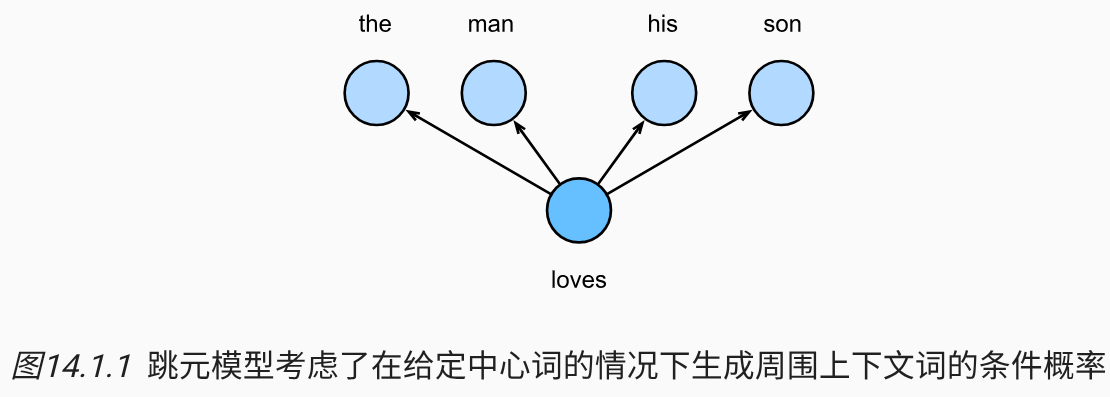
跳元模型中, 每一个词都有两个$d$维向量表示, 对于词典中索引为 $i$ 的任何词, 分别使用 $\mathbf{v}_i \in \mathbb{R}^d$ 以及 $\mathbf{u}_i \in \mathbb{R}^d$ 分别用于表示中心词以及上下文词时的两个向量, 给定中心词 $w_c$, 生成任何上下文词 $w_o$, 其中下标表示词典中的索引, 对应 $w_o$ 的条件概率如下:
$$
P(w_o \mid w_c) = softmax(\mathbf{u}^T \mathbf{v}_c) = \frac {\exp (\mathbf{u}_o^T \mathbf{v}_c)}{\sum_{i \in \mathcal{Y} \exp (\mathbf{u}_i^T \mathbf{v}_c)}}
$$
其中就是 $w_o$ 对于 $w_c$ 的余弦相似度对比

同时给定长度为 $T$ 的文本序列, 其中时间步$t$处的词表示为 $w^{(t)}$, 假设上下文词是在给定任何中心词的情况下独立生成的, 对于上下文窗口 $m$, 那么跳元模型的似然函数, 那么给定任意中心词的情况喜爱, 生成所由上下文概率为:
$$
\prod_{t=1}^{T} \prod_{\substack{-m \leq j \leq m, \\ j \neq 0}} P(w^{(t+j)} \mid w^{(t)}),
$$
#### 训练
这里使用最大似然估计, 最大化似然函数(极大似然估计)来计算模型参数, 相当于最小化以下损失函数:
$$
-\sum_{t=1}^T \sum_{-m \leq j \leq m, j \neq 0} \log P(w^{(t+j)} \mid {w^{(t)}})
$$
利用随机梯度下降来最小化损失, 每一次迭代过程中可以随机抽样一个较短的序列来计算该子序列的随机梯度从而更新模型参数, 为了计算该随机梯度, 需要获取到对数条件概率关于中心词向量与上下文向量的梯度, 此时涉及到中心词 $w_c$ 和上下文词 $w_o$ 的对数条件概率:
$$
\log P(w_o \mid w_c) = \mathbf{u}_o^T \mathbf{v}_c - \log (\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^T \mathbf{v}_c))
$$
所以可以发现对于中心词梯度为:
$$
\begin{align}
\frac{\partial \log P(w_o \mid w_c)}{\partial \mathbf{v}_c} &= \mathbf{u}_o - \frac{\sum_{j \in \mathcal{V}} \exp(\mathbf{u}_j^\top \mathbf{v}_c) \mathbf{u}_j}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)} \\
&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} \left( \frac{\exp(\mathbf{u}_j^\top \mathbf{v}_c)}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)} \right) \mathbf{u}_j \\
&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j.
\end{align}
$$
上述计算需要词典 以$w_c$ 为中心词的所由词的条件概率, 其他此项梁的梯度也可以通过相同的方式获取 ; 对词典中索引为$i$的词进行训练之后, 得到$\mathbf{v}_i$(中心词)和$\mathbf{u}_i$(上下文)两个词向量 ; 一般在自然语言处理中, 跳元模型中的中心词向量通常用于词表示

### 连续词袋模型
和跳元模型相反, 该模型假设中心词是基于其在文本序列中周围的上下文生成的, 例如文本序列 `the man loves his son`, 在 `loves` 为中心词并且上下文窗口为 $2$, 考虑基于上下文词以及生成中心词的条件概率为 $P(loves \mid the, man, his, son)$
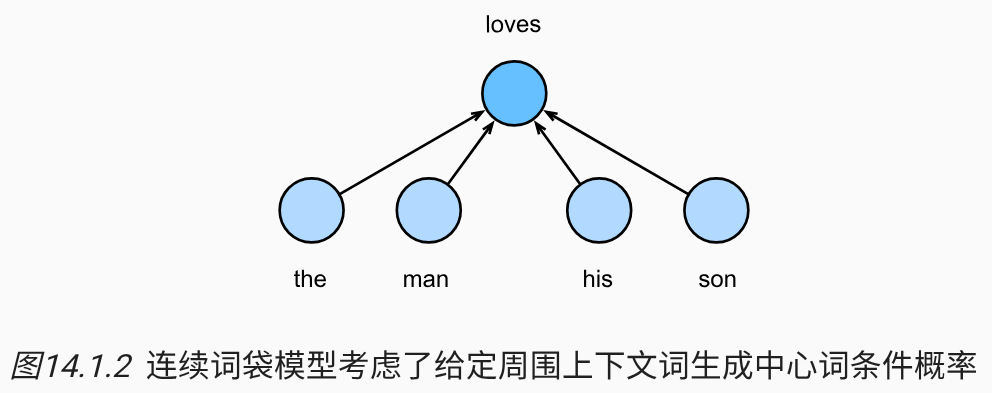
对字典中索引为 $i$ 的任意词, 分别使用 $\mathbf{v}_i \in \mathbb{R}^d$ 以及 $\mathbf{u}_i \in \mathbb{R}^d$ 分别表示上下文词和中心词向量, 给定上下文词 $w_{o_1}, \ldots, w_{o_{2m}}$, 生成任意中心词 $w_c$ 的条件为:
$$
P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\exp\left( \frac{1}{2m} \mathbf{u}_c^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}{\sum_{i \in \mathcal{V}} \exp\left( \frac{1}{2m} \mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}.
$$
同时可以设 $\mathcal{W}_o = {w_{o_1}, \ldots, w_{o_{2m}}}$ 以及  $\bar{\mathbf{v}}_o = \frac {(\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}})}{2m}$, 所以上面条件概率可以简化为:
$$
P(w_c \mid \mathcal{W}_o) = \frac{\exp\left( \mathbf{u}_c^\top \bar{\mathbf{v}}_o \right)}{\sum_{i \in \mathcal{V}} \exp\left( \mathbf{u}_i^\top \bar{\mathbf{v}}_o \right)}.
$$
可以理解为上下文词平均成一个词, 对于中心词产生的贡献 ; 给定长度为 $T$ 的文本序列, 时间步$t$处的词可以标识为 $w^{(t)}$, 对于上下文窗口$m$, 联系词袋模型的似然函数是在给定其上下文词的情况下生成所由中心词的概率:
$$
\prod_{t=1}^{T} P\bigl(w^{(t)} \mid w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}\bigr).
$$
#### 训练
还是最大似然估计, 也就是最小化如下损失函数:
$$
-\sum_{t=1}^{T} \log P\bigl(w^{(t)} \mid w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}\bigr) 
$$
利用随机梯度下降, 其中一个表达时可以表示为如下形式:
$$
\log P(w_c \mid \mathcal{W}_o) = \mathbf{u}_c^\top \bar{\mathbf{v}}_o - \log \left( \sum_{i \in \mathcal{V}} \exp\bigl( \mathbf{u}_i^\top \bar{\mathbf{v}}_o \bigr) \right) 
$$
对于任意上下文词向量 $\mathbf{v}_{o_i}$ 计算梯度, 如下:
$$
\frac{\partial \log P(w_c \mid \mathcal{W}_o)}{\partial \mathbf{v}_{o_i}} 
= \frac{1}{2m} \left( \mathbf{u}_c - \sum_{j \in \mathcal{V}} \frac{\exp\bigl( \mathbf{u}_j^\top \bar{\mathbf{v}}_o \bigr) \mathbf{u}_j}{\sum_{i \in \mathcal{V}} \exp\bigl( \mathbf{u}_i^\top \bar{\mathbf{v}}_o \bigr)} \right) 
= \frac{1}{2m} \left( \mathbf{u}_c - \sum_{j \in \mathcal{V}} P(w_j \mid \mathcal{W}_o) \mathbf{u}_j \right) 
$$
在词袋模型中, 使用上下文词向量作为词向量表示